In [4]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
from scipy.stats import norm
from utils.plot_utils import *
import matplotlib.pyplot as plt
from astropy import units, constants

## Phase Modulation

In [8]:
def phase_modulation(t, β, ω):
    return np.exp(1j*β*np.sin(ω*t))

In [92]:
Γ = 1/(100e-9)
β = 2.2
ωphase = 2*np.pi * 1.6e6 # 1.6 MHz
t = np.linspace(0,100e-6, 6001)
s = phase_modulation(t,β,ωphase)

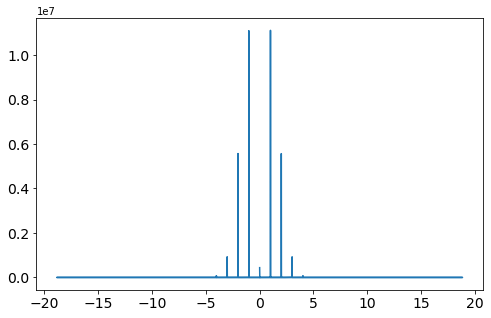

In [96]:
fourier_transform = np.fft.fft(s)
fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(fftfreq*2*np.pi/Γ, np.abs(fourier_transform**2))
set_fontsize(ax, 14)

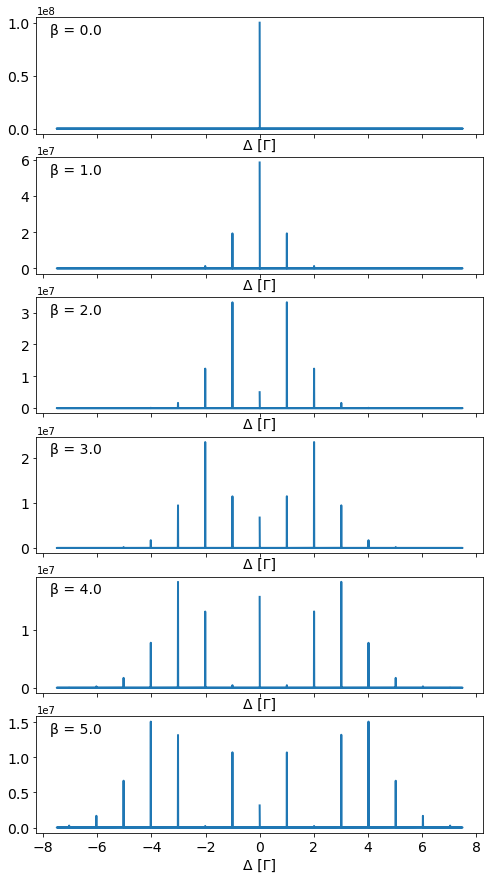

In [115]:
betas = [0,1,2,3,4,5]
fig, axes = plt.subplots(len(betas), figsize = (8,15), sharex = True)

for idx, β in enumerate(betas):
    t = np.linspace(0,100e-6, 10001)
    s = phase_modulation(t,β,ωphase)
    
    fourier_transform = np.fft.fft(s)
    fftfreq = np.fft.fftfreq(len(fourier_transform), np.diff(t)[0])
    fftfreq *= 2*np.pi
    m = np.abs(fftfreq/Γ) < 7.5

    axes[idx].plot(fftfreq[m]/Γ, np.abs(fourier_transform**2)[m], lw = 2)
    
    axes[idx].text(0.03, 0.95, f"β = {β:.1f}", transform = axes[idx].transAxes,
        ha = 'left', va = 'top', fontsize = 14);
    
    axes[idx].set_xlabel("Δ [Γ]")
    
    set_fontsize(axes[idx], 14)